In [1]:
import time
import numpy as np
import tkinter as tk
from PIL import ImageTk, Image

PhotoImage = ImageTk.PhotoImage
UNIT = 50  # 픽셀 수
HEIGHT = 5  # 그리드 세로
WIDTH = 5  # 그리드 가로

np.random.seed(1)


class Env(tk.Tk):
    def __init__(self):
        super(Env, self).__init__()
        self.action_space = ['u', 'd', 'l', 'r']
        self.action_size = len(self.action_space)
        self.title('DeepSARSA')
        self.geometry('{0}x{1}'.format(HEIGHT * UNIT, HEIGHT * UNIT))
        self.shapes = self.load_images()
        self.canvas = self._build_canvas()
        self.counter = 0
        self.rewards = []
        self.goal = []
        # 장애물 설정
        self.set_reward([0, 1], -1)
        self.set_reward([1, 2], -1)
        self.set_reward([2, 3], -1)
        # 목표 지점 설정
        self.set_reward([4, 4], 1)

    def _build_canvas(self):
        canvas = tk.Canvas(self, bg='white',
                           height=HEIGHT * UNIT,
                           width=WIDTH * UNIT)
        # 그리드 생성
        for c in range(0, WIDTH * UNIT, UNIT):  # 0~400 by 80
            x0, y0, x1, y1 = c, 0, c, HEIGHT * UNIT
            canvas.create_line(x0, y0, x1, y1)
        for r in range(0, HEIGHT * UNIT, UNIT):  # 0~400 by 80
            x0, y0, x1, y1 = 0, r, HEIGHT * UNIT, r
            canvas.create_line(x0, y0, x1, y1)

        self.rewards = []
        self.goal = []
        # 캔버스에 이미지 추가
        x, y = UNIT/2, UNIT/2
        self.rectangle = canvas.create_image(x, y, image=self.shapes[0])

        canvas.pack()

        return canvas

    def load_images(self):
        rectangle = PhotoImage(
            Image.open("../img/rectangle.png").resize((30, 30)))
        triangle = PhotoImage(
            Image.open("../img/triangle.png").resize((30, 30)))
        circle = PhotoImage(
            Image.open("../img/circle.png").resize((30, 30)))

        return rectangle, triangle, circle

    def reset_reward(self):

        for reward in self.rewards:
            self.canvas.delete(reward['figure'])

        self.rewards.clear()
        self.goal.clear()
        self.set_reward([0, 1], -1)
        self.set_reward([1, 2], -1)
        self.set_reward([2, 3], -1)

        # #goal
        self.set_reward([4, 4], 1)

    def set_reward(self, state, reward):
        state = [int(state[0]), int(state[1])]
        x = int(state[0])
        y = int(state[1])
        temp = {}
        if reward > 0:
            temp['reward'] = reward
            temp['figure'] = self.canvas.create_image((UNIT * x) + UNIT / 2,
                                                       (UNIT * y) + UNIT / 2,
                                                       image=self.shapes[2])

            self.goal.append(temp['figure'])


        elif reward < 0:
            temp['direction'] = -1
            temp['reward'] = reward
            temp['figure'] = self.canvas.create_image((UNIT * x) + UNIT / 2,
                                                      (UNIT * y) + UNIT / 2,
                                                      image=self.shapes[1])

        temp['coords'] = self.canvas.coords(temp['figure'])
        temp['state'] = state
        self.rewards.append(temp)

    # new methods

    def check_if_reward(self, state):
        check_list = dict()
        check_list['if_goal'] = False
        rewards = 0

        for reward in self.rewards:
            if reward['state'] == state:
                rewards += reward['reward']
                if reward['reward'] == 1:
                    check_list['if_goal'] = True

        check_list['rewards'] = rewards

        return check_list

    def coords_to_state(self, coords):
        x = int((coords[0] - UNIT / 2) / UNIT)
        y = int((coords[1] - UNIT / 2) / UNIT)
        return [x, y]

    def reset(self):
        self.update()
        time.sleep(0.5)
        x, y = self.canvas.coords(self.rectangle)
        self.canvas.move(self.rectangle, UNIT / 2 - x, UNIT / 2 - y)
        self.reset_reward()
        return self.get_state()

    def step(self, action):
        self.counter += 1
        self.render()

        if self.counter % 2 == 1:
            self.rewards = self.move_rewards()

        next_coords = self.move(self.rectangle, action)
        check = self.check_if_reward(self.coords_to_state(next_coords))
        done = check['if_goal']
        reward = check['rewards']

        self.canvas.tag_raise(self.rectangle)

        s_ = self.get_state()

        return s_, reward, done

    def get_state(self):

        location = self.coords_to_state(self.canvas.coords(self.rectangle))
        agent_x = location[0]
        agent_y = location[1]

        states = list()

        for reward in self.rewards:
            reward_location = reward['state']
            states.append(reward_location[0] - agent_x)
            states.append(reward_location[1] - agent_y)
            if reward['reward'] < 0:
                states.append(-1)
                states.append(reward['direction'])
            else:
                states.append(1)

        return states

    def move_rewards(self):
        new_rewards = []
        for temp in self.rewards:
            if temp['reward'] == 1:
                new_rewards.append(temp)
                continue
            temp['coords'] = self.move_const(temp)
            temp['state'] = self.coords_to_state(temp['coords'])
            new_rewards.append(temp)
        return new_rewards

    def move_const(self, target):

        s = self.canvas.coords(target['figure'])

        base_action = np.array([0, 0])

        if s[0] == (WIDTH - 1) * UNIT + UNIT / 2:
            target['direction'] = 1
        elif s[0] == UNIT / 2:
            target['direction'] = -1

        if target['direction'] == -1:
            base_action[0] += UNIT
        elif target['direction'] == 1:
            base_action[0] -= UNIT

        if (target['figure'] is not self.rectangle
           and s == [(WIDTH - 1) * UNIT, (HEIGHT - 1) * UNIT]):
            base_action = np.array([0, 0])

        self.canvas.move(target['figure'], base_action[0], base_action[1])

        s_ = self.canvas.coords(target['figure'])

        return s_

    def move(self, target, action):
        s = self.canvas.coords(target)

        base_action = np.array([0, 0])

        if action == 0:  # 상
            if s[1] > UNIT:
                base_action[1] -= UNIT
        elif action == 1:  # 하
            if s[1] < (HEIGHT - 1) * UNIT:
                base_action[1] += UNIT
        elif action == 2:  # 우
            if s[0] < (WIDTH - 1) * UNIT:
                base_action[0] += UNIT
        elif action == 3:  # 좌
            if s[0] > UNIT:
                base_action[0] -= UNIT

        self.canvas.move(target, base_action[0], base_action[1])

        s_ = self.canvas.coords(target)

        return s_

    def render(self):
        # 게임 속도 조정
        time.sleep(0.05)
        self.update()


Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 155       
Total params: 1,565
Trainable params: 1,565
Non-trainable params: 0
_________________________________________________________________
episode: 0   score: -17 global_step 133   epsilon: 0.9867873979365388
episode: 1   score: -2 global_step 173   epsilon: 0.9828479355460494
episode: 2   score: -15 global_step 357   epsilon: 0.9649280064714622
episode: 3   score: -12 global_step 448   epsilon: 0.9561865584476045
episode: 4   score: -19 global_step 695   epsilon: 0.9328568914851036
episode: 5   score: -13 global_st

episode: 106   score: -2 global_step 4599   epsilon: 0.6313322584079054
episode: 107   score: 1 global_step 4616   epsilon: 0.6302598517513275
episode: 108   score: 0 global_step 4652   epsilon: 0.6279948824257438
episode: 109   score: 0 global_step 4677   epsilon: 0.6264267777607327
episode: 110   score: 1 global_step 4716   epsilon: 0.6239883494301238
episode: 111   score: -12 global_step 4769   epsilon: 0.6206897951383026
episode: 112   score: 1 global_step 4779   epsilon: 0.6200693845791024
episode: 113   score: 0 global_step 4790   epsilon: 0.619387649191936
episode: 114   score: -1 global_step 4831   epsilon: 0.6168532322125683
episode: 115   score: 0 global_step 4844   epsilon: 0.6160518039798372
episode: 116   score: -11 global_step 4897   epsilon: 0.6127952041989956
episode: 117   score: -5 global_step 4923   epsilon: 0.6112039266601402
episode: 118   score: 0 global_step 4955   epsilon: 0.6092511026369294
episode: 119   score: -1 global_step 4978   epsilon: 0.6078513654277099

episode: 221   score: 1 global_step 7347   epsilon: 0.4796317114232334
episode: 222   score: 0 global_step 7367   epsilon: 0.47867335875409084
episode: 223   score: 1 global_step 7379   epsilon: 0.4780992665427183
episode: 224   score: -3 global_step 7418   epsilon: 0.4762382177533474
episode: 225   score: 1 global_step 7428   epsilon: 0.4757621937856535
episode: 226   score: 1 global_step 7440   epsilon: 0.47519159305151454
episode: 227   score: 1 global_step 7456   epsilon: 0.474431856466523
episode: 228   score: 0 global_step 7475   epsilon: 0.4735312467581706
episode: 229   score: 1 global_step 7489   epsilon: 0.4728687337538259
episode: 230   score: 1 global_step 7507   epsilon: 0.47201829313651555
episode: 231   score: 1 global_step 7519   epsilon: 0.4714521826130046
episode: 232   score: -1 global_step 7540   epsilon: 0.47046312245235156
episode: 233   score: 1 global_step 7553   epsilon: 0.4698518872198804
episode: 234   score: 0 global_step 7572   epsilon: 0.4689599716257855
e

episode: 336   score: 1 global_step 9771   epsilon: 0.3763826908963842
episode: 337   score: 1 global_step 9782   epsilon: 0.3759688768847875
episode: 338   score: 0 global_step 9795   epsilon: 0.37548041049306113
episode: 339   score: -2 global_step 9809   epsilon: 0.3749550794689071
episode: 340   score: -2 global_step 9859   epsilon: 0.3730848899307937
episode: 341   score: 0 global_step 9867   epsilon: 0.37278652646172816
episode: 342   score: 0 global_step 9881   epsilon: 0.37226496442476387
episode: 343   score: 1 global_step 9899   epsilon: 0.3715954567505406
episode: 344   score: 1 global_step 9918   epsilon: 0.37089006045101364
episode: 345   score: 1 global_step 9930   epsilon: 0.3704452370843349
episode: 346   score: 1 global_step 9946   epsilon: 0.3698529690319025
episode: 347   score: 1 global_step 9957   epsilon: 0.36944633412408684
episode: 348   score: 1 global_step 9973   epsilon: 0.3688556631182666
episode: 349   score: 1 global_step 9999   epsilon: 0.3678978362165908

episode: 450   score: 0 global_step 11974   epsilon: 0.30196025567544027
episode: 451   score: 1 global_step 12003   epsilon: 0.30108579578997374
episode: 452   score: 1 global_step 12020   epsilon: 0.30057435920914644
episode: 453   score: 0 global_step 12031   epsilon: 0.30024389268032914
episode: 454   score: 1 global_step 12041   epsilon: 0.2999437838613776
episode: 455   score: 1 global_step 12052   epsilon: 0.2996140106187304
episode: 456   score: 1 global_step 12065   epsilon: 0.2992247460181861
episode: 457   score: 1 global_step 12076   epsilon: 0.2988957633218143
episode: 458   score: 1 global_step 12084   epsilon: 0.29865673038523455
episode: 459   score: 0 global_step 12094   epsilon: 0.2983582080145455
episode: 460   score: 1 global_step 12104   epsilon: 0.29805998403192785
episode: 461   score: 1 global_step 12118   epsilon: 0.2976429711804046
episode: 462   score: 1 global_step 12135   epsilon: 0.29713738272151247
episode: 463   score: 1 global_step 12155   epsilon: 0.29

episode: 563   score: 1 global_step 14184   epsilon: 0.2420838985394885
episode: 564   score: 1 global_step 14194   epsilon: 0.2418419235496584
episode: 565   score: 1 global_step 14204   epsilon: 0.24160019042595837
episode: 566   score: 1 global_step 14214   epsilon: 0.24135869892663117
episode: 567   score: 1 global_step 14226   epsilon: 0.2410692277315736
episode: 568   score: -1 global_step 14270   epsilon: 0.2400108004549982
episode: 569   score: 1 global_step 14283   epsilon: 0.23969897355420516
episode: 570   score: 1 global_step 14295   epsilon: 0.23941149293454075
episode: 571   score: 1 global_step 14308   epsilon: 0.23910044466623578
episode: 572   score: 1 global_step 14321   epsilon: 0.23878980051815096
episode: 573   score: 1 global_step 14336   epsilon: 0.23843186643804756
episode: 574   score: 1 global_step 14348   epsilon: 0.23814590551091055
episode: 575   score: 0 global_step 14367   epsilon: 0.23769383528926716
episode: 576   score: 0 global_step 14382   epsilon: 0

episode: 676   score: 0 global_step 16106   epsilon: 0.19975162976027763
episode: 677   score: 0 global_step 16184   epsilon: 0.19819955042173534
episode: 678   score: 1 global_step 16202   epsilon: 0.1978430943146182
episode: 679   score: 0 global_step 16265   epsilon: 0.1966005388512921
episode: 680   score: 1 global_step 16282   epsilon: 0.1962665851783362
episode: 681   score: 1 global_step 16293   epsilon: 0.19605079984888435
episode: 682   score: 1 global_step 16306   epsilon: 0.1957960866726482
episode: 683   score: 1 global_step 16317   epsilon: 0.19558081863285606
episode: 684   score: 1 global_step 16333   epsilon: 0.19526812391053625
episode: 685   score: 1 global_step 16350   epsilon: 0.19493643353180096
episode: 686   score: 1 global_step 16359   epsilon: 0.19476106090236622
episode: 687   score: 1 global_step 16370   epsilon: 0.19454693082182803
episode: 688   score: 1 global_step 16382   epsilon: 0.1943136028630255
episode: 689   score: 1 global_step 16397   epsilon: 0.1

episode: 789   score: 1 global_step 18014   epsilon: 0.16505276373224412
episode: 790   score: 1 global_step 18026   epsilon: 0.1648548093142861
episode: 791   score: 1 global_step 18038   epsilon: 0.16465709231102318
episode: 792   score: 1 global_step 18049   epsilon: 0.16447606004371884
episode: 793   score: 1 global_step 18062   epsilon: 0.16426236940996045
episode: 794   score: 1 global_step 18078   epsilon: 0.16399974664179084
episode: 795   score: 1 global_step 18092   epsilon: 0.16377029617658231
episode: 796   score: 1 global_step 18103   epsilon: 0.1635902388974343
episode: 797   score: 1 global_step 18116   epsilon: 0.16337769914047884
episode: 798   score: 1 global_step 18130   epsilon: 0.16314911897593526
episode: 799   score: 1 global_step 18144   epsilon: 0.1629208586156973
episode: 800   score: 1 global_step 18162   epsilon: 0.16262785020620915
episode: 801   score: 1 global_step 18180   epsilon: 0.16233536876379426
episode: 802   score: 1 global_step 18195   epsilon: 0

episode: 902   score: 1 global_step 19727   epsilon: 0.13906711209063718
episode: 903   score: 1 global_step 19737   epsilon: 0.13892810754206186
episode: 904   score: 1 global_step 19747   epsilon: 0.13878924193549977
episode: 905   score: 1 global_step 19757   epsilon: 0.13865051513207136
episode: 906   score: 1 global_step 19770   epsilon: 0.1384703775701573
episode: 907   score: 1 global_step 19783   epsilon: 0.138290474046618
episode: 908   score: 1 global_step 19793   epsilon: 0.13815224578669277
episode: 909   score: 1 global_step 19806   epsilon: 0.13797275558642014
episode: 910   score: 1 global_step 19815   epsilon: 0.13784862976499637
episode: 911   score: 1 global_step 19825   epsilon: 0.13771084315057586
episode: 912   score: 1 global_step 19837   epsilon: 0.13754568099766212
episode: 913   score: 1 global_step 19847   epsilon: 0.1374081971957183
episode: 914   score: 1 global_step 19858   epsilon: 0.13725712373064367
episode: 915   score: 1 global_step 19868   epsilon: 0.

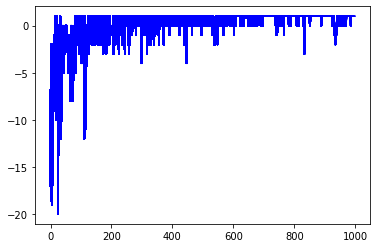

In [2]:
import copy
import pylab
import random
import numpy as np
from environment import Env
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

EPISODES = 1000


# 그리드월드 예제에서의 딥살사 에이전트
class DeepSARSAgent:
    def __init__(self):
        self.load_model = False
        # 에이전트가 가능한 모든 행동 정의
        self.action_space = [0, 1, 2, 3, 4]
        # 상태의 크기와 행동의 크기 정의
        self.action_size = len(self.action_space)
        self.state_size = 15
        self.discount_factor = 0.99
        self.learning_rate = 0.001

        self.epsilon = 1.  # exploration
        self.epsilon_decay = .9999
        self.epsilon_min = 0.01
        self.model = self.build_model()

        if self.load_model:
            self.epsilon = 0.05
            self.model.load_weights('./save_model/deep_sarsa_trained.h5')

    # 상태가 입력 큐함수가 출력인 인공신경망 생성
    def build_model(self):
        model = Sequential()
        model.add(Dense(30, input_dim=self.state_size, activation='relu'))
        model.add(Dense(30, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # 입실론 탐욕 방법으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            # 무작위 행동 반환
            return random.randrange(self.action_size)
        else:
            # 모델로부터 행동 산출
            state = np.float32(state)
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])

    def train_model(self, state, action, reward, next_state, next_action, done):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        state = np.float32(state)
        next_state = np.float32(next_state)
        target = self.model.predict(state)[0]
        # 살사의 큐함수 업데이트 식
        if done:
            target[action] = reward
        else:
            target[action] = (reward + self.discount_factor *
                              self.model.predict(next_state)[0][next_action])

        # 출력 값 reshape
        target = np.reshape(target, [1, 5])
        # 인공신경망 업데이트
        self.model.fit(state, target, epochs=1, verbose=0)


if __name__ == "__main__":
    # 환경과 에이전트 생성
    env = Env()
    agent = DeepSARSAgent()

    global_step = 0
    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, 15])

        while not done:
            # env 초기화
            global_step += 1

            # 현재 상태에 대한 행동 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행 후 샘플 수집
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, 15])
            next_action = agent.get_action(next_state)
            # 샘플로 모델 학습
            agent.train_model(state, action, reward, next_state, next_action,
                              done)
            state = next_state
            score += reward

            state = copy.deepcopy(next_state)

            if done:
                # 에피소드마다 학습 결과 출력
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./save_graph/deep_sarsa_.png")
                print("episode:", e, "  score:", score, "global_step",
                      global_step, "  epsilon:", agent.epsilon)

        # 100 에피소드마다 모델 저장
        if e % 100 == 0:
            agent.model.save_weights("./save_model/deep_sarsa.h5")
